In [20]:
import os
import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt
from keras import layers, models
from keras.optimizers import Adam
import tensorflow as tf

In [21]:
# dir 
input_folder = "clean_testset_wav"
clean_folder = "processed_clean"
noisy_folder = "processed_noisy"
denoised_baseline_folder = "denoised_baseline"
denoised_tuned_folder = "denoised_tuned"

# check if all folders above exists in the dir if not create them
if not os.path.exists(input_folder):
    os.makedirs(input_folder, exist_ok=True)
if not os.path.exists(clean_folder):
    os.makedirs(clean_folder, exist_ok=True)
if not os.path.exists(noisy_folder):
    os.makedirs(noisy_folder, exist_ok=True)
if not os.path.exists(denoised_baseline_folder):
    os.makedirs(denoised_baseline_folder, exist_ok=True)
if not os.path.exists(denoised_tuned_folder):
    os.makedirs(denoised_tuned_folder, exist_ok=True)

# set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [22]:
# process audio files (truncate to 2 seconds)
def process_audio(input_folder, output_folder, max_files=20):
    os.makedirs(output_folder, exist_ok=True)
    valid_files = []
    for idx, file in enumerate(os.listdir(input_folder)):
        if file.endswith('.wav'):
            try:
                audio, sr = librosa.load(os.path.join(input_folder, file), sr=44100, mono=True)
                # 2 seconds at 44.1kHz
                if len(audio) >= 88200:  
                    truncated = librosa.util.fix_length(audio, size=88200)
                    sf.write(os.path.join(output_folder, file), truncated, 44100)
                    valid_files.append(file)
                    print(f"Processed: {file}")
            except Exception as e:
                print(f"Error processing {file}: {e}")
            # stop at 20 files
            if len(valid_files) == max_files:
                break
    print(f"Processed {len(valid_files)} files")
    return valid_files  

In [23]:
# process clean audio files
#os.makedirs(clean_folder, exist_ok=True)
valid_files = process_audio(input_folder, clean_folder, max_files=20)

Processed: p232_238.wav
Processed: p257_330.wav
Processed: p257_080.wav
Processed: p232_042.wav
Processed: p257_013.wav
Processed: p232_251.wav
Processed: p257_069.wav
Processed: p257_234.wav
Processed: p232_121.wav
Processed: p257_189.wav
Processed: p232_356.wav
Processed: p232_311.wav
Processed: p257_273.wav
Processed: p257_219.wav
Processed: p232_175.wav
Processed: p257_203.wav
Processed: p257_308.wav
Processed: p257_402.wav
Processed: p257_243.wav
Processed: p257_303.wav
Processed 20 files


In [24]:
# edit valid_files.txt
with open("valid_files.txt", "w") as f:
    for file in valid_files:
        f.write(f"{file}\n")

In [25]:
# add noise to clean audio
def add_noise(clean_audio, noise_type=None):
    noise_types = ['gaussian', 'white', 'background']
    if noise_type is None:
        noise_type = np.random.choice(noise_types)
    if noise_type == 'gaussian':
        noise = 0.1 * np.random.normal(0, 1, len(clean_audio))
    elif noise_type == 'white':
        noise = 0.1 * np.random.uniform(-1, 1, len(clean_audio))
    elif noise_type == 'background':
        noise = 0.05 * np.random.randn(len(clean_audio))
    
    noisy_audio = np.clip(clean_audio + noise, -1.0, 1.0)
    return noisy_audio

In [26]:
# generate noisy versions
#os.makedirs(noisy_folder, exist_ok=True)
for file in valid_files:
    clean, sr = librosa.load(os.path.join(clean_folder, file), sr=44100)
    noisy = add_noise(clean)
    sf.write(os.path.join(noisy_folder, file), noisy, sr)

In [27]:
# load data from files
def load_data(file_list, folder):
    X = []
    for file in file_list:
        audio, _ = librosa.load(os.path.join(folder, file), sr=44100)
        X.append(audio.reshape(-1, 1))
    return np.array(X)

In [28]:
#load data for training 
X_clean = load_data(valid_files, clean_folder)
X_noisy = load_data(valid_files, noisy_folder)

In [29]:
# calculate signal-to-noise ratio (SNR) in dB
def calculate_snr(clean, noisy):
    noise = clean - noisy
    signal_power = np.sum(clean ** 2)
    noise_power = np.sum(noise ** 2)
    if noise_power == 0:
        return float('inf') 
    snr = 10 * np.log10(signal_power / noise_power)
    return snr

In [30]:
# plot waveforms for comparison
def plot_waveforms(clean, noisy, denoised, title):
    plt.figure(figsize=(15, 9))
    plt.subplot(3, 1, 1)
    plt.plot(clean)
    plt.title('Clean Audio')
    plt.xlim(0, len(clean))
    plt.subplot(3, 1, 2)
    plt.plot(noisy)
    plt.title(f'Noisy Audio (SNR: {calculate_snr(clean, noisy):.2f} dB)')
    plt.xlim(0, len(noisy))
    plt.subplot(3, 1, 3)
    plt.plot(denoised)
    plt.title(f'Denoised Audio (SNR: {calculate_snr(clean, denoised):.2f} dB)')
    plt.xlim(0, len(denoised))
    plt.tight_layout()
    plt.show()

In [31]:
def build_model(input_shape=(88200, 1)):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        # Encoder
        layers.Conv1D(32, 16, padding='same', activation='relu'),
        layers.MaxPooling1D(5),
        layers.Conv1D(64, 16, padding='same', activation='relu'),
        layers.MaxPooling1D(5),
        # layers.Conv1D(128, 16, padding='same', activation='relu'),
        # layers.MaxPooling1D(4),
        # layers.Conv1D(256, 16, padding='same', activation='relu'),
        # layers.MaxPooling1D(2),
        # Decoder
        # layers.Conv1DTranspose(256, 16, padding='same', activation='relu'),
        # # layers.UpSampling1D(2),
        # layers.Conv1DTranspose(128, 16, padding='same', activation='relu'),
        # layers.UpSampling1D(4),
        layers.Conv1DTranspose(64, 16, padding='same', activation='relu'),
        layers.UpSampling1D(5),
        layers.Conv1DTranspose(32, 16, padding='same', activation='relu'),
        layers.UpSampling1D(5),
        layers.Conv1D(1, 16, padding='same', activation='tanh')
    ])
    model.summary()
    return model

In [32]:
# baseline model training
model = build_model()
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_noisy, X_clean, epochs=30,batch_size=min(32, len(valid_files)), validation_split=0.2, verbose=1 )

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 88200, 32)      │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 17640, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 17640, 64)      │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 3528, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_2              │ (None, 3528, 64)       │        65,600 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_2 (UpSampling1D)  │ (None, 17640, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_3              │ (None, 17640, 32)      │        32,800 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_3 (UpSampling1D)  │ (None, 88200, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 88200, 1)       │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,289 (516.75 KB)

 Trainable params: 132,289 (516.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0050 - val_loss: 0.0047
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0068 - val_loss: 0.0031
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0042 - val_loss: 0.0035
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0051 - val_loss: 0.0030
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0041 - val_loss: 0.0030
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0039 - val_loss: 0.0027
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0036 - val_loss: 0.0022
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0030 - val_loss: 0.0018
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0025 - val_loss: 0.0014
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0019 - val_loss: 0.0011
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0017 - val_loss: 0.0011
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0016 - val_loss: 0.0012
Epoch 13/30
1/1 ━━━━━━━━━

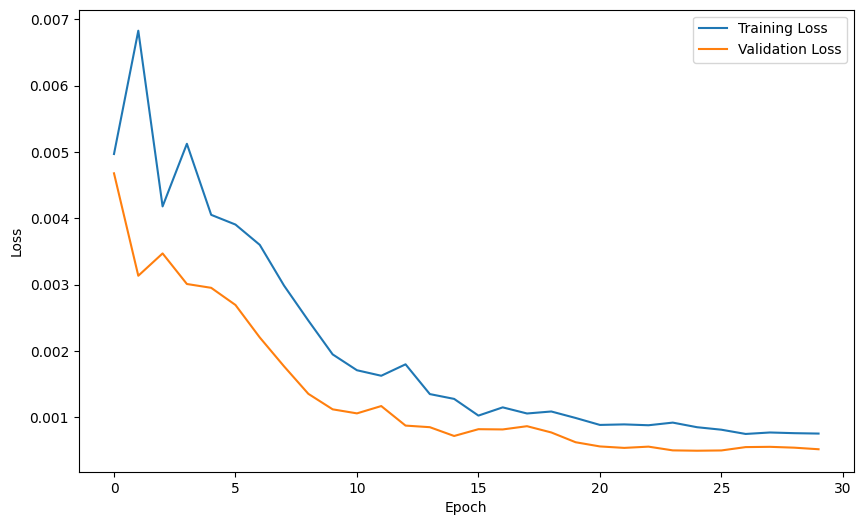

In [33]:
# plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step


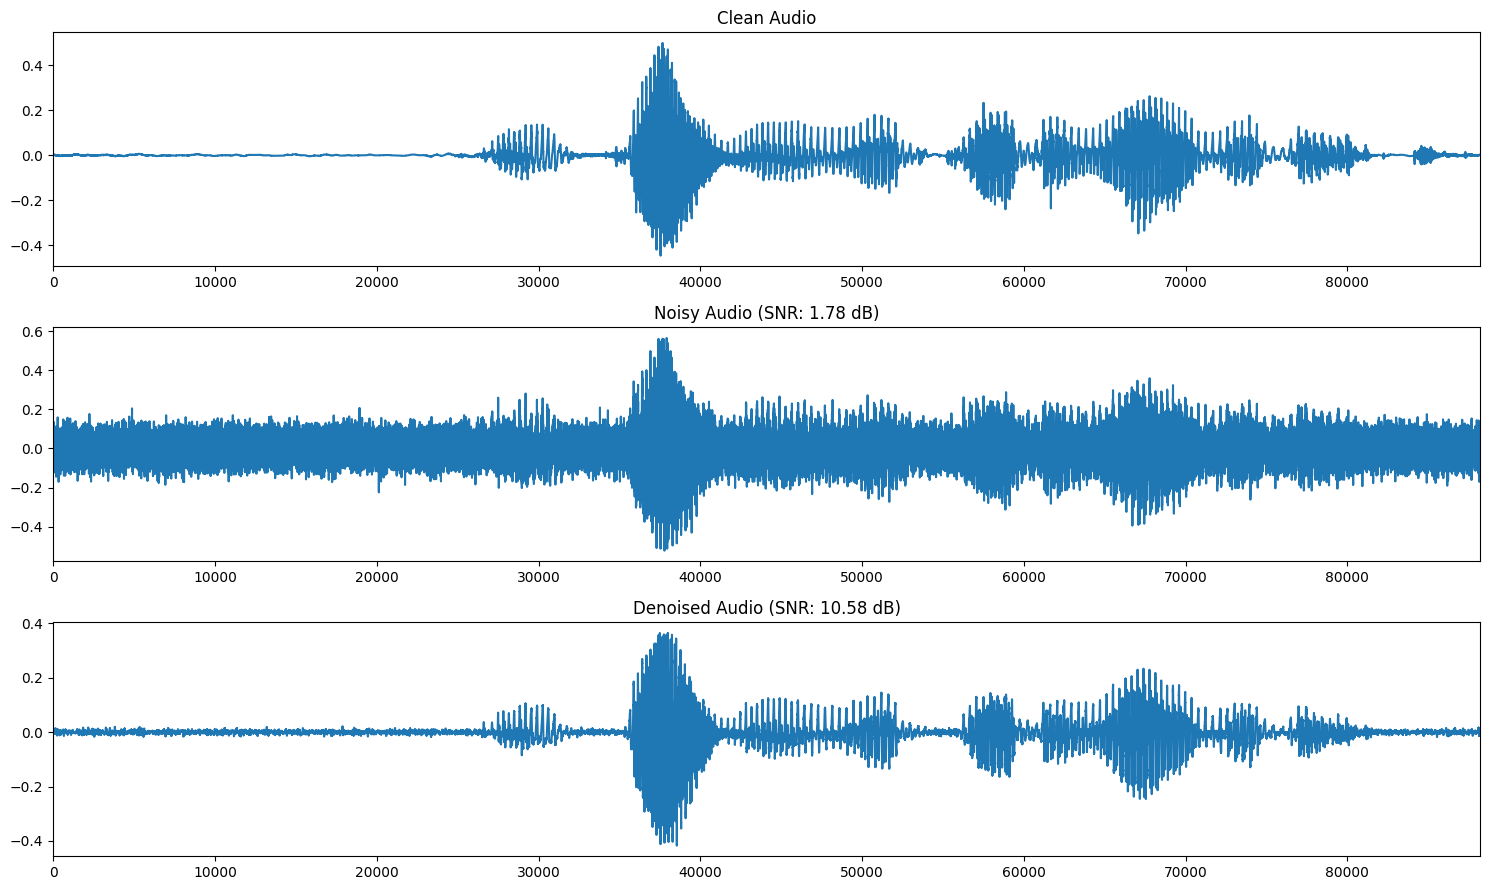

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step


In [34]:
# generate and save denoised outputs using baseline model
os.makedirs(denoised_baseline_folder, exist_ok=True)
for idx, file in enumerate(valid_files):
    denoised = model.predict(X_noisy[idx].reshape(1, 88200, 1))
    sf.write(os.path.join(denoised_baseline_folder, file), denoised.flatten(), 44100)
    if idx == 0:
        plot_waveforms(X_clean[idx].flatten(), X_noisy[idx].flatten(), denoised.flatten(), "baseline_comparison")   

In [35]:
# save baseline model
model.save("denoise_baseline.h5")

In [61]:
# hyperparameter tuning on learning rate, epoch, batch size, filter size
learning_rates = [0.001, 0.0005, 0.0001]
batch_sizes = [16, 32, 64]
epochs = [30, 50, 100]
best_loss = float('inf')
best_model = None
#print how many iterations are there
print(f"{len(learning_rates) * len(batch_sizes) * len(epochs)} iterations in total")

for lr in learning_rates:
    for bs in batch_sizes:
        for ep in epochs:
            print(f"Training with learning rate: {lr}, batch size: {bs}, epochs: {ep}")
            model = build_model(input_shape=(88200, 1))
            model.compile(optimizer=Adam(lr), loss='mse')
            history = model.fit(X_noisy, X_clean, epochs=ep, batch_size=bs, validation_split=0.2, verbose=1)
            val_loss = history.history['val_loss'][-1]
            print(f"Validation loss: {val_loss}")
            if val_loss < best_loss:
                best_loss = val_loss
                best_model = model
                print(f"New best model found with validation loss: {best_loss}")
                # print how many iterations more are remaining
                print(f"{len(learning_rates) * len(batch_sizes) * len(epochs) - (learning_rates.index(lr) * len(batch_sizes) * len(epochs) + batch_sizes.index(bs) * len(epochs) + epochs.index(ep) + 1)} iterations remaining")

27 iterations in total
Training with learning rate: 0.001, batch size: 16, epochs: 30


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_48 (Conv1D)              │ (None, 88200, 32)      │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_35 (MaxPooling1D) │ (None, 17640, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_49 (Conv1D)              │ (None, 17640, 64)      │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_36 (MaxPooling1D) │ (None, 3528, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_35             │ (None, 3528, 64)       │        65,600 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_35 (UpSampling1D) │ (None, 17640, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_36             │ (None, 17640, 32)      │        32,800 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_36 (UpSampling1D) │ (None, 88200, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_50 (Conv1D)              │ (None, 88200, 1)       │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,289 (516.75 KB)

 Trainable params: 132,289 (516.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0052 - val_loss: 0.0048
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.0068 - val_loss: 0.0035
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0046 - val_loss: 0.0036
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0048 - val_loss: 0.0032
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0042 - val_loss: 0.0030
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0040 - val_loss: 0.0026
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0035 - val_loss: 0.0020
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0028 - val_loss: 0.0016
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0025 - val_loss: 0.0011
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0018 - val_loss: 0.0010
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0018 - val_loss: 9.0570e-04
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0016 - val_loss: 0.0011
Epoch 13/30
1/1 ━━━━━

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_51 (Conv1D)              │ (None, 88200, 32)      │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_37 (MaxPooling1D) │ (None, 17640, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_52 (Conv1D)              │ (None, 17640, 64)      │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_38 (MaxPooling1D) │ (None, 3528, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_37             │ (None, 3528, 64)       │        65,600 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_37 (UpSampling1D) │ (None, 17640, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_38             │ (None, 17640, 32)      │        32,800 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_38 (UpSampling1D) │ (None, 88200, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_53 (Conv1D)              │ (None, 88200, 1)       │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,289 (516.75 KB)

 Trainable params: 132,289 (516.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0048 - val_loss: 0.0132
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0227 - val_loss: 0.0033
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0046 - val_loss: 0.0036
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0049 - val_loss: 0.0036
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0049 - val_loss: 0.0032
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0042 - val_loss: 0.0031
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0040 - val_loss: 0.0029
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0038 - val_loss: 0.0024
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0033 - val_loss: 0.0022
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0031 - val_loss: 0.0017
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0025 - val_loss: 0.0015
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0024 - val_loss: 0.0012
Epoch 13/50
1/1 ━━━━━━━━━

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_54 (Conv1D)              │ (None, 88200, 32)      │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_39 (MaxPooling1D) │ (None, 17640, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_55 (Conv1D)              │ (None, 17640, 64)      │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_40 (MaxPooling1D) │ (None, 3528, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_39             │ (None, 3528, 64)       │        65,600 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_39 (UpSampling1D) │ (None, 17640, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_40             │ (None, 17640, 32)      │        32,800 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_40 (UpSampling1D) │ (None, 88200, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_56 (Conv1D)              │ (None, 88200, 1)       │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,289 (516.75 KB)

 Trainable params: 132,289 (516.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0048 - val_loss: 0.0029
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0041 - val_loss: 0.0069
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0119 - val_loss: 0.0025
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0032 - val_loss: 0.0034
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0049 - val_loss: 0.0032
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0045 - val_loss: 0.0029
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0039 - val_loss: 0.0026
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0035 - val_loss: 0.0023
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0030 - val_loss: 0.0019
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0025 - val_loss: 0.0015
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0020 - val_loss: 0.0011
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0015 - val_loss: 8.6158e-04
Epoch 13/

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_57 (Conv1D)              │ (None, 88200, 32)      │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_41 (MaxPooling1D) │ (None, 17640, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_58 (Conv1D)              │ (None, 17640, 64)      │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_42 (MaxPooling1D) │ (None, 3528, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_41             │ (None, 3528, 64)       │        65,600 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_41 (UpSampling1D) │ (None, 17640, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_42             │ (None, 17640, 32)      │        32,800 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_42 (UpSampling1D) │ (None, 88200, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_59 (Conv1D)              │ (None, 88200, 1)       │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,289 (516.75 KB)

 Trainable params: 132,289 (516.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0050 - val_loss: 0.0036
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0048 - val_loss: 0.0040
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0056 - val_loss: 0.0031
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0041 - val_loss: 0.0029
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0037 - val_loss: 0.0025
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0033 - val_loss: 0.0019
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0025 - val_loss: 0.0013
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0019 - val_loss: 9.0373e-04
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0015 - val_loss: 0.0011
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0018 - val_loss: 0.0012
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0020 - val_loss: 8.1889e-04
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0013 - val_loss: 7.9652e-04
Epoch 13/30
1

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_60 (Conv1D)              │ (None, 88200, 32)      │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_43 (MaxPooling1D) │ (None, 17640, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_61 (Conv1D)              │ (None, 17640, 64)      │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_44 (MaxPooling1D) │ (None, 3528, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_43             │ (None, 3528, 64)       │        65,600 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_43 (UpSampling1D) │ (None, 17640, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_44             │ (None, 17640, 32)      │        32,800 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_44 (UpSampling1D) │ (None, 88200, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_62 (Conv1D)              │ (None, 88200, 1)       │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,289 (516.75 KB)

 Trainable params: 132,289 (516.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0051 - val_loss: 0.0051
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0075 - val_loss: 0.0038
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0052 - val_loss: 0.0035
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0047 - val_loss: 0.0034
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0044 - val_loss: 0.0032
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0043 - val_loss: 0.0028
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0039 - val_loss: 0.0024
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0033 - val_loss: 0.0021
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0031 - val_loss: 0.0016
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0025 - val_loss: 0.0015
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0024 - val_loss: 0.0013
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0019 - val_loss: 0.0014
Epoch 13/50
1/1 ━━━━━━━━━

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_63 (Conv1D)              │ (None, 88200, 32)      │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_45 (MaxPooling1D) │ (None, 17640, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_64 (Conv1D)              │ (None, 17640, 64)      │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_46 (MaxPooling1D) │ (None, 3528, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_45             │ (None, 3528, 64)       │        65,600 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_45 (UpSampling1D) │ (None, 17640, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_46             │ (None, 17640, 32)      │        32,800 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_46 (UpSampling1D) │ (None, 88200, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_65 (Conv1D)              │ (None, 88200, 1)       │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,289 (516.75 KB)

 Trainable params: 132,289 (516.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0050 - val_loss: 0.0044
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0059 - val_loss: 0.0035
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0046 - val_loss: 0.0034
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0045 - val_loss: 0.0032
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0042 - val_loss: 0.0029
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0038 - val_loss: 0.0025
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0034 - val_loss: 0.0021
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0029 - val_loss: 0.0016
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0023 - val_loss: 0.0013
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0019 - val_loss: 0.0010
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0018 - val_loss: 0.0014
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0020 - val_loss: 0.0012
Epoch 13/100


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_66 (Conv1D)              │ (None, 88200, 32)      │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_47 (MaxPooling1D) │ (None, 17640, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_67 (Conv1D)              │ (None, 17640, 64)      │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_48 (MaxPooling1D) │ (None, 3528, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_47             │ (None, 3528, 64)       │        65,600 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_47 (UpSampling1D) │ (None, 17640, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_48             │ (None, 17640, 32)      │        32,800 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_48 (UpSampling1D) │ (None, 88200, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_68 (Conv1D)              │ (None, 88200, 1)       │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,289 (516.75 KB)

 Trainable params: 132,289 (516.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0051 - val_loss: 0.0051
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0075 - val_loss: 0.0035
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0046 - val_loss: 0.0036
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0047 - val_loss: 0.0034
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0045 - val_loss: 0.0032
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0043 - val_loss: 0.0029
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0040 - val_loss: 0.0026
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0036 - val_loss: 0.0021
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0030 - val_loss: 0.0016
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0024 - val_loss: 0.0013
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0021 - val_loss: 0.0020
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0036 - val_loss: 0.0018
Epoch 13/30
1/1 ━━━━━━━━━

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_69 (Conv1D)              │ (None, 88200, 32)      │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_49 (MaxPooling1D) │ (None, 17640, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_70 (Conv1D)              │ (None, 17640, 64)      │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_50 (MaxPooling1D) │ (None, 3528, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_49             │ (None, 3528, 64)       │        65,600 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_49 (UpSampling1D) │ (None, 17640, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_50             │ (None, 17640, 32)      │        32,800 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_50 (UpSampling1D) │ (None, 88200, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_71 (Conv1D)              │ (None, 88200, 1)       │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,289 (516.75 KB)

 Trainable params: 132,289 (516.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0055 - val_loss: 0.0057
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0088 - val_loss: 0.0034
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0046 - val_loss: 0.0034
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0045 - val_loss: 0.0034
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0044 - val_loss: 0.0031
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0041 - val_loss: 0.0028
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0037 - val_loss: 0.0023
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0032 - val_loss: 0.0017
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0026 - val_loss: 0.0012
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0020 - val_loss: 0.0011
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0017 - val_loss: 0.0014
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0021 - val_loss: 0.0023
Epoch 13/50
1/1 ━━━━━━━━━

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_72 (Conv1D)              │ (None, 88200, 32)      │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_51 (MaxPooling1D) │ (None, 17640, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_73 (Conv1D)              │ (None, 17640, 64)      │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_52 (MaxPooling1D) │ (None, 3528, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_51             │ (None, 3528, 64)       │        65,600 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_51 (UpSampling1D) │ (None, 17640, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_52             │ (None, 17640, 32)      │        32,800 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_52 (UpSampling1D) │ (None, 88200, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_74 (Conv1D)              │ (None, 88200, 1)       │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,289 (516.75 KB)

 Trainable params: 132,289 (516.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0050 - val_loss: 0.0034
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0045 - val_loss: 0.0033
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0047 - val_loss: 0.0027
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0040 - val_loss: 0.0021
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0030 - val_loss: 0.0020
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0028 - val_loss: 0.0015
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0021 - val_loss: 0.0014
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0021 - val_loss: 0.0010
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0016 - val_loss: 0.0011
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0019 - val_loss: 9.3418e-04
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0015 - val_loss: 9.6357e-04
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0015 - val_loss: 8.2318e-04
E

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_75 (Conv1D)              │ (None, 88200, 32)      │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_53 (MaxPooling1D) │ (None, 17640, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_76 (Conv1D)              │ (None, 17640, 64)      │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_54 (MaxPooling1D) │ (None, 3528, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_53             │ (None, 3528, 64)       │        65,600 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_53 (UpSampling1D) │ (None, 17640, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_54             │ (None, 17640, 32)      │        32,800 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_54 (UpSampling1D) │ (None, 88200, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_77 (Conv1D)              │ (None, 88200, 1)       │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,289 (516.75 KB)

 Trainable params: 132,289 (516.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0052 - val_loss: 0.0038
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0049 - val_loss: 0.0035
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0046 - val_loss: 0.0032
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0042 - val_loss: 0.0028
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0038 - val_loss: 0.0023
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0033 - val_loss: 0.0020
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0028 - val_loss: 0.0016
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0024 - val_loss: 0.0013
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0020 - val_loss: 0.0013
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0020 - val_loss: 0.0013
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0020 - val_loss: 0.0010
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0015 - val_loss: 0.0011
Epoch 13/30
1/1 ━━━━━━━━━

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_78 (Conv1D)              │ (None, 88200, 32)      │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_55 (MaxPooling1D) │ (None, 17640, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_79 (Conv1D)              │ (None, 17640, 64)      │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_56 (MaxPooling1D) │ (None, 3528, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_55             │ (None, 3528, 64)       │        65,600 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_55 (UpSampling1D) │ (None, 17640, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_56             │ (None, 17640, 32)      │        32,800 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_56 (UpSampling1D) │ (None, 88200, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_80 (Conv1D)              │ (None, 88200, 1)       │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,289 (516.75 KB)

 Trainable params: 132,289 (516.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0051 - val_loss: 0.0040
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0055 - val_loss: 0.0031
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0041 - val_loss: 0.0032
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0042 - val_loss: 0.0027
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0037 - val_loss: 0.0022
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0030 - val_loss: 0.0019
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0027 - val_loss: 0.0015
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0021 - val_loss: 0.0012
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0019 - val_loss: 0.0010
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0017 - val_loss: 0.0011
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0018 - val_loss: 8.9977e-04
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0015 - val_loss: 9.1986e-04
Epoch 13/50
1/1 ━

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_81 (Conv1D)              │ (None, 88200, 32)      │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_57 (MaxPooling1D) │ (None, 17640, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_82 (Conv1D)              │ (None, 17640, 64)      │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_58 (MaxPooling1D) │ (None, 3528, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_57             │ (None, 3528, 64)       │        65,600 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_57 (UpSampling1D) │ (None, 17640, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_58             │ (None, 17640, 32)      │        32,800 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_58 (UpSampling1D) │ (None, 88200, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_83 (Conv1D)              │ (None, 88200, 1)       │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,289 (516.75 KB)

 Trainable params: 132,289 (516.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0050 - val_loss: 0.0054
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0083 - val_loss: 0.0032
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0044 - val_loss: 0.0031
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0043 - val_loss: 0.0031
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0045 - val_loss: 0.0029
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0039 - val_loss: 0.0028
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0037 - val_loss: 0.0026
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0036 - val_loss: 0.0024
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0032 - val_loss: 0.0021
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0029 - val_loss: 0.0018
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0027 - val_loss: 0.0016
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0024 - val_loss: 0.0014
Epoch 13/100


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_84 (Conv1D)              │ (None, 88200, 32)      │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_59 (MaxPooling1D) │ (None, 17640, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_85 (Conv1D)              │ (None, 17640, 64)      │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_60 (MaxPooling1D) │ (None, 3528, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_59             │ (None, 3528, 64)       │        65,600 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_59 (UpSampling1D) │ (None, 17640, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_60             │ (None, 17640, 32)      │        32,800 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_60 (UpSampling1D) │ (None, 88200, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_86 (Conv1D)              │ (None, 88200, 1)       │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,289 (516.75 KB)

 Trainable params: 132,289 (516.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.0053 - val_loss: 0.0050
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0076 - val_loss: 0.0032
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0043 - val_loss: 0.0037
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0054 - val_loss: 0.0034
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0048 - val_loss: 0.0030
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0041 - val_loss: 0.0028
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0038 - val_loss: 0.0028
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0038 - val_loss: 0.0026
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0037 - val_loss: 0.0024
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0034 - val_loss: 0.0021
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0030 - val_loss: 0.0019
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0027 - val_loss: 0.0017
Epoch 13/30
1/1 ━━━━━━━━━

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_87 (Conv1D)              │ (None, 88200, 32)      │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_61 (MaxPooling1D) │ (None, 17640, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_88 (Conv1D)              │ (None, 17640, 64)      │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_62 (MaxPooling1D) │ (None, 3528, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_61             │ (None, 3528, 64)       │        65,600 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_61 (UpSampling1D) │ (None, 17640, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_62             │ (None, 17640, 32)      │        32,800 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_62 (UpSampling1D) │ (None, 88200, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_89 (Conv1D)              │ (None, 88200, 1)       │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,289 (516.75 KB)

 Trainable params: 132,289 (516.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0051 - val_loss: 0.0037
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0048 - val_loss: 0.0032
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0043 - val_loss: 0.0029
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0039 - val_loss: 0.0024
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0033 - val_loss: 0.0020
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0028 - val_loss: 0.0015
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0023 - val_loss: 0.0013
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0021 - val_loss: 0.0011
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0017 - val_loss: 0.0011
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0017 - val_loss: 0.0010
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0016 - val_loss: 8.8259e-04
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0014 - val_loss: 9.0277e-04
Epoch 13/50
1/1 ━

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_90 (Conv1D)              │ (None, 88200, 32)      │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_63 (MaxPooling1D) │ (None, 17640, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_91 (Conv1D)              │ (None, 17640, 64)      │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_64 (MaxPooling1D) │ (None, 3528, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_63             │ (None, 3528, 64)       │        65,600 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_63 (UpSampling1D) │ (None, 17640, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_64             │ (None, 17640, 32)      │        32,800 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_64 (UpSampling1D) │ (None, 88200, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_92 (Conv1D)              │ (None, 88200, 1)       │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,289 (516.75 KB)

 Trainable params: 132,289 (516.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0051 - val_loss: 0.0032
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0046 - val_loss: 0.0029
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0042 - val_loss: 0.0025
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0037 - val_loss: 0.0020
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0029 - val_loss: 0.0018
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0028 - val_loss: 0.0014
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0022 - val_loss: 0.0013
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0021 - val_loss: 0.0012
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0018 - val_loss: 0.0011
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0017 - val_loss: 9.8276e-04
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0015 - val_loss: 9.0303e-04
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0014 - val_loss: 8.1975e-04
E

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_93 (Conv1D)              │ (None, 88200, 32)      │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_65 (MaxPooling1D) │ (None, 17640, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_94 (Conv1D)              │ (None, 17640, 64)      │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_66 (MaxPooling1D) │ (None, 3528, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_65             │ (None, 3528, 64)       │        65,600 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_65 (UpSampling1D) │ (None, 17640, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_66             │ (None, 17640, 32)      │        32,800 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_66 (UpSampling1D) │ (None, 88200, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_95 (Conv1D)              │ (None, 88200, 1)       │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,289 (516.75 KB)

 Trainable params: 132,289 (516.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0053 - val_loss: 0.0048
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0073 - val_loss: 0.0035
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0048 - val_loss: 0.0033
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0045 - val_loss: 0.0035
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0047 - val_loss: 0.0032
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0043 - val_loss: 0.0029
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0039 - val_loss: 0.0028
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0037 - val_loss: 0.0026
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0036 - val_loss: 0.0023
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0031 - val_loss: 0.0019
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0027 - val_loss: 0.0017
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0024 - val_loss: 0.0014
Epoch 13/30
1/1 ━━━━━━━━━

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_96 (Conv1D)              │ (None, 88200, 32)      │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_67 (MaxPooling1D) │ (None, 17640, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_97 (Conv1D)              │ (None, 17640, 64)      │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_68 (MaxPooling1D) │ (None, 3528, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_67             │ (None, 3528, 64)       │        65,600 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_67 (UpSampling1D) │ (None, 17640, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_68             │ (None, 17640, 32)      │        32,800 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_68 (UpSampling1D) │ (None, 88200, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_98 (Conv1D)              │ (None, 88200, 1)       │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,289 (516.75 KB)

 Trainable params: 132,289 (516.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0050 - val_loss: 0.0043
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0064 - val_loss: 0.0031
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0042 - val_loss: 0.0031
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0044 - val_loss: 0.0030
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0042 - val_loss: 0.0026
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0037 - val_loss: 0.0023
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0032 - val_loss: 0.0020
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0029 - val_loss: 0.0017
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0026 - val_loss: 0.0014
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0021 - val_loss: 0.0012
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0020 - val_loss: 0.0011
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0017 - val_loss: 0.0010
Epoch 13/50
1/1 ━━━━━━━━━

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_99 (Conv1D)              │ (None, 88200, 32)      │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_69 (MaxPooling1D) │ (None, 17640, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_100 (Conv1D)             │ (None, 17640, 64)      │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_70 (MaxPooling1D) │ (None, 3528, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_69             │ (None, 3528, 64)       │        65,600 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_69 (UpSampling1D) │ (None, 17640, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_70             │ (None, 17640, 32)      │        32,800 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_70 (UpSampling1D) │ (None, 88200, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_101 (Conv1D)             │ (None, 88200, 1)       │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,289 (516.75 KB)

 Trainable params: 132,289 (516.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0049 - val_loss: 0.0042
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0060 - val_loss: 0.0029
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0039 - val_loss: 0.0031
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0045 - val_loss: 0.0027
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0038 - val_loss: 0.0026
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0035 - val_loss: 0.0025
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0035 - val_loss: 0.0022
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0031 - val_loss: 0.0018
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0026 - val_loss: 0.0016
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0024 - val_loss: 0.0013
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0020 - val_loss: 0.0011
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0017 - val_loss: 0.0010
Epoch 13/100


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_102 (Conv1D)             │ (None, 88200, 32)      │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_71 (MaxPooling1D) │ (None, 17640, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_103 (Conv1D)             │ (None, 17640, 64)      │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_72 (MaxPooling1D) │ (None, 3528, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_71             │ (None, 3528, 64)       │        65,600 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_71 (UpSampling1D) │ (None, 17640, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_72             │ (None, 17640, 32)      │        32,800 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_72 (UpSampling1D) │ (None, 88200, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_104 (Conv1D)             │ (None, 88200, 1)       │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,289 (516.75 KB)

 Trainable params: 132,289 (516.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0052 - val_loss: 0.0037
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0050 - val_loss: 0.0035
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0047 - val_loss: 0.0033
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0045 - val_loss: 0.0032
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0043 - val_loss: 0.0030
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0041 - val_loss: 0.0028
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0039 - val_loss: 0.0027
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0037 - val_loss: 0.0025
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0036 - val_loss: 0.0024
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0034 - val_loss: 0.0022
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0032 - val_loss: 0.0021
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0030 - val_loss: 0.0020
Epoch 13/30
1/1 ━━━━━━━━━

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_105 (Conv1D)             │ (None, 88200, 32)      │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_73 (MaxPooling1D) │ (None, 17640, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_106 (Conv1D)             │ (None, 17640, 64)      │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_74 (MaxPooling1D) │ (None, 3528, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_73             │ (None, 3528, 64)       │        65,600 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_73 (UpSampling1D) │ (None, 17640, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_74             │ (None, 17640, 32)      │        32,800 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_74 (UpSampling1D) │ (None, 88200, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_107 (Conv1D)             │ (None, 88200, 1)       │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,289 (516.75 KB)

 Trainable params: 132,289 (516.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0056 - val_loss: 0.0040
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0053 - val_loss: 0.0039
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0051 - val_loss: 0.0038
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0050 - val_loss: 0.0037
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0049 - val_loss: 0.0036
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0048 - val_loss: 0.0035
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0047 - val_loss: 0.0034
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0046 - val_loss: 0.0034
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0045 - val_loss: 0.0033
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0044 - val_loss: 0.0032
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0043 - val_loss: 0.0031
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0042 - val_loss: 0.0030
Epoch 13/50
1/1 ━━━━━━━━━

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_108 (Conv1D)             │ (None, 88200, 32)      │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_75 (MaxPooling1D) │ (None, 17640, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_109 (Conv1D)             │ (None, 17640, 64)      │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_76 (MaxPooling1D) │ (None, 3528, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_75             │ (None, 3528, 64)       │        65,600 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_75 (UpSampling1D) │ (None, 17640, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_76             │ (None, 17640, 32)      │        32,800 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_76 (UpSampling1D) │ (None, 88200, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_110 (Conv1D)             │ (None, 88200, 1)       │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,289 (516.75 KB)

 Trainable params: 132,289 (516.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0054 - val_loss: 0.0041
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0052 - val_loss: 0.0040
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0050 - val_loss: 0.0038
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0049 - val_loss: 0.0037
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0048 - val_loss: 0.0036
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0046 - val_loss: 0.0035
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0045 - val_loss: 0.0034
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0044 - val_loss: 0.0033
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0043 - val_loss: 0.0032
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0042 - val_loss: 0.0031
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0040 - val_loss: 0.0030
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0039 - val_loss: 0.0029
Epoch 13/100


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_111 (Conv1D)             │ (None, 88200, 32)      │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_77 (MaxPooling1D) │ (None, 17640, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_112 (Conv1D)             │ (None, 17640, 64)      │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_78 (MaxPooling1D) │ (None, 3528, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_77             │ (None, 3528, 64)       │        65,600 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_77 (UpSampling1D) │ (None, 17640, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_78             │ (None, 17640, 32)      │        32,800 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_78 (UpSampling1D) │ (None, 88200, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_113 (Conv1D)             │ (None, 88200, 1)       │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,289 (516.75 KB)

 Trainable params: 132,289 (516.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0056 - val_loss: 0.0039
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0050 - val_loss: 0.0037
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0048 - val_loss: 0.0037
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0047 - val_loss: 0.0036
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0046 - val_loss: 0.0034
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0045 - val_loss: 0.0033
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0043 - val_loss: 0.0032
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0042 - val_loss: 0.0032
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0041 - val_loss: 0.0031
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0040 - val_loss: 0.0029
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0039 - val_loss: 0.0028
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0037 - val_loss: 0.0027
Epoch 13/30
1/1 ━━━━━━━━━

Model: "sequential_34"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_114 (Conv1D)             │ (None, 88200, 32)      │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_79 (MaxPooling1D) │ (None, 17640, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_115 (Conv1D)             │ (None, 17640, 64)      │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_80 (MaxPooling1D) │ (None, 3528, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_79             │ (None, 3528, 64)       │        65,600 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_79 (UpSampling1D) │ (None, 17640, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_80             │ (None, 17640, 32)      │        32,800 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_80 (UpSampling1D) │ (None, 88200, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_116 (Conv1D)             │ (None, 88200, 1)       │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,289 (516.75 KB)

 Trainable params: 132,289 (516.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0049 - val_loss: 0.0037
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0047 - val_loss: 0.0036
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0045 - val_loss: 0.0034
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0044 - val_loss: 0.0032
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0042 - val_loss: 0.0031
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0040 - val_loss: 0.0029
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0038 - val_loss: 0.0028
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0037 - val_loss: 0.0026
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0035 - val_loss: 0.0024
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0033 - val_loss: 0.0023
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0032 - val_loss: 0.0021
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0030 - val_loss: 0.0020
Epoch 13/50
1/1 ━━━━━━━━━

Model: "sequential_35"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_117 (Conv1D)             │ (None, 88200, 32)      │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_81 (MaxPooling1D) │ (None, 17640, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_118 (Conv1D)             │ (None, 17640, 64)      │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_82 (MaxPooling1D) │ (None, 3528, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_81             │ (None, 3528, 64)       │        65,600 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_81 (UpSampling1D) │ (None, 17640, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_82             │ (None, 17640, 32)      │        32,800 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_82 (UpSampling1D) │ (None, 88200, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_119 (Conv1D)             │ (None, 88200, 1)       │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,289 (516.75 KB)

 Trainable params: 132,289 (516.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0055 - val_loss: 0.0042
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0052 - val_loss: 0.0041
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0051 - val_loss: 0.0039
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0049 - val_loss: 0.0037
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0047 - val_loss: 0.0036
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0045 - val_loss: 0.0034
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0044 - val_loss: 0.0033
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0042 - val_loss: 0.0031
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0041 - val_loss: 0.0030
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0039 - val_loss: 0.0028
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0037 - val_loss: 0.0027
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0036 - val_loss: 0.0025
Epoch 13/100


Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_120 (Conv1D)             │ (None, 88200, 32)      │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_83 (MaxPooling1D) │ (None, 17640, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_121 (Conv1D)             │ (None, 17640, 64)      │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_84 (MaxPooling1D) │ (None, 3528, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_83             │ (None, 3528, 64)       │        65,600 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_83 (UpSampling1D) │ (None, 17640, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_84             │ (None, 17640, 32)      │        32,800 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_84 (UpSampling1D) │ (None, 88200, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_122 (Conv1D)             │ (None, 88200, 1)       │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,289 (516.75 KB)

 Trainable params: 132,289 (516.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0050 - val_loss: 0.0037
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0048 - val_loss: 0.0036
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0047 - val_loss: 0.0035
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0046 - val_loss: 0.0034
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0045 - val_loss: 0.0033
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0044 - val_loss: 0.0032
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0042 - val_loss: 0.0031
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0041 - val_loss: 0.0030
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0040 - val_loss: 0.0029
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0039 - val_loss: 0.0027
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0037 - val_loss: 0.0026
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0036 - val_loss: 0.0025
Epoch 13/30
1/1 ━━━━━━━━━

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_123 (Conv1D)             │ (None, 88200, 32)      │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_85 (MaxPooling1D) │ (None, 17640, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_124 (Conv1D)             │ (None, 17640, 64)      │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_86 (MaxPooling1D) │ (None, 3528, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_85             │ (None, 3528, 64)       │        65,600 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_85 (UpSampling1D) │ (None, 17640, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_86             │ (None, 17640, 32)      │        32,800 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_86 (UpSampling1D) │ (None, 88200, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_125 (Conv1D)             │ (None, 88200, 1)       │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,289 (516.75 KB)

 Trainable params: 132,289 (516.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0053 - val_loss: 0.0040
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0050 - val_loss: 0.0039
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0048 - val_loss: 0.0037
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0046 - val_loss: 0.0035
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0044 - val_loss: 0.0033
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0042 - val_loss: 0.0032
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0040 - val_loss: 0.0030
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0039 - val_loss: 0.0029
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0037 - val_loss: 0.0028
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0036 - val_loss: 0.0026
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0034 - val_loss: 0.0025
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0032 - val_loss: 0.0023
Epoch 13/50
1/1 ━━━━━━━━━

Model: "sequential_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_126 (Conv1D)             │ (None, 88200, 32)      │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_87 (MaxPooling1D) │ (None, 17640, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_127 (Conv1D)             │ (None, 17640, 64)      │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_88 (MaxPooling1D) │ (None, 3528, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_87             │ (None, 3528, 64)       │        65,600 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_87 (UpSampling1D) │ (None, 17640, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_transpose_88             │ (None, 17640, 32)      │        32,800 │
│ (Conv1DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_88 (UpSampling1D) │ (None, 88200, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_128 (Conv1D)             │ (None, 88200, 1)       │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,289 (516.75 KB)

 Trainable params: 132,289 (516.75 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.0051 - val_loss: 0.0037
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0048 - val_loss: 0.0036
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0047 - val_loss: 0.0035
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0046 - val_loss: 0.0034
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0044 - val_loss: 0.0032
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0043 - val_loss: 0.0031
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0041 - val_loss: 0.0029
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0039 - val_loss: 0.0028
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0037 - val_loss: 0.0026
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0036 - val_loss: 0.0025
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0034 - val_loss: 0.0023
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0032 - val_loss: 0.0022
Epoch 13/100


In [62]:
# save best model
best_model.save("denoise_tuned.h5")

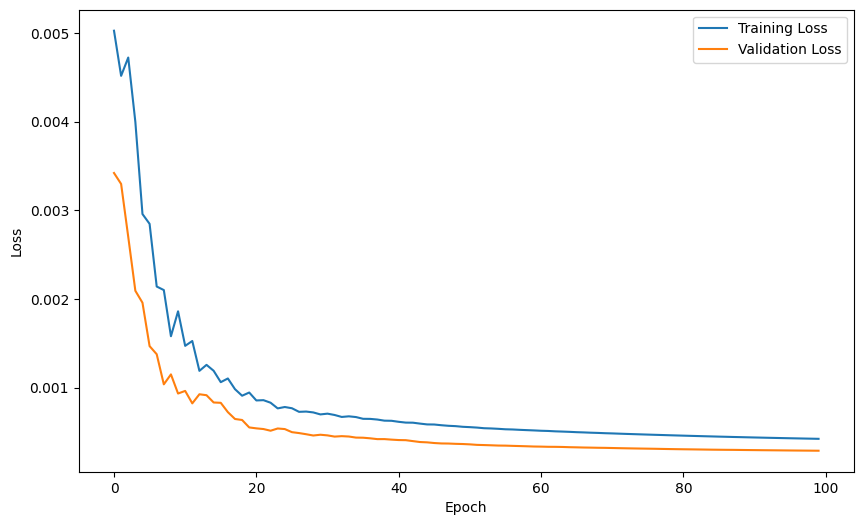

In [63]:
# plot training history for best model
plt.figure(figsize=(10, 6))
plt.plot(best_model.history.history['loss'], label='Training Loss')
plt.plot(best_model.history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
best_model.summary()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


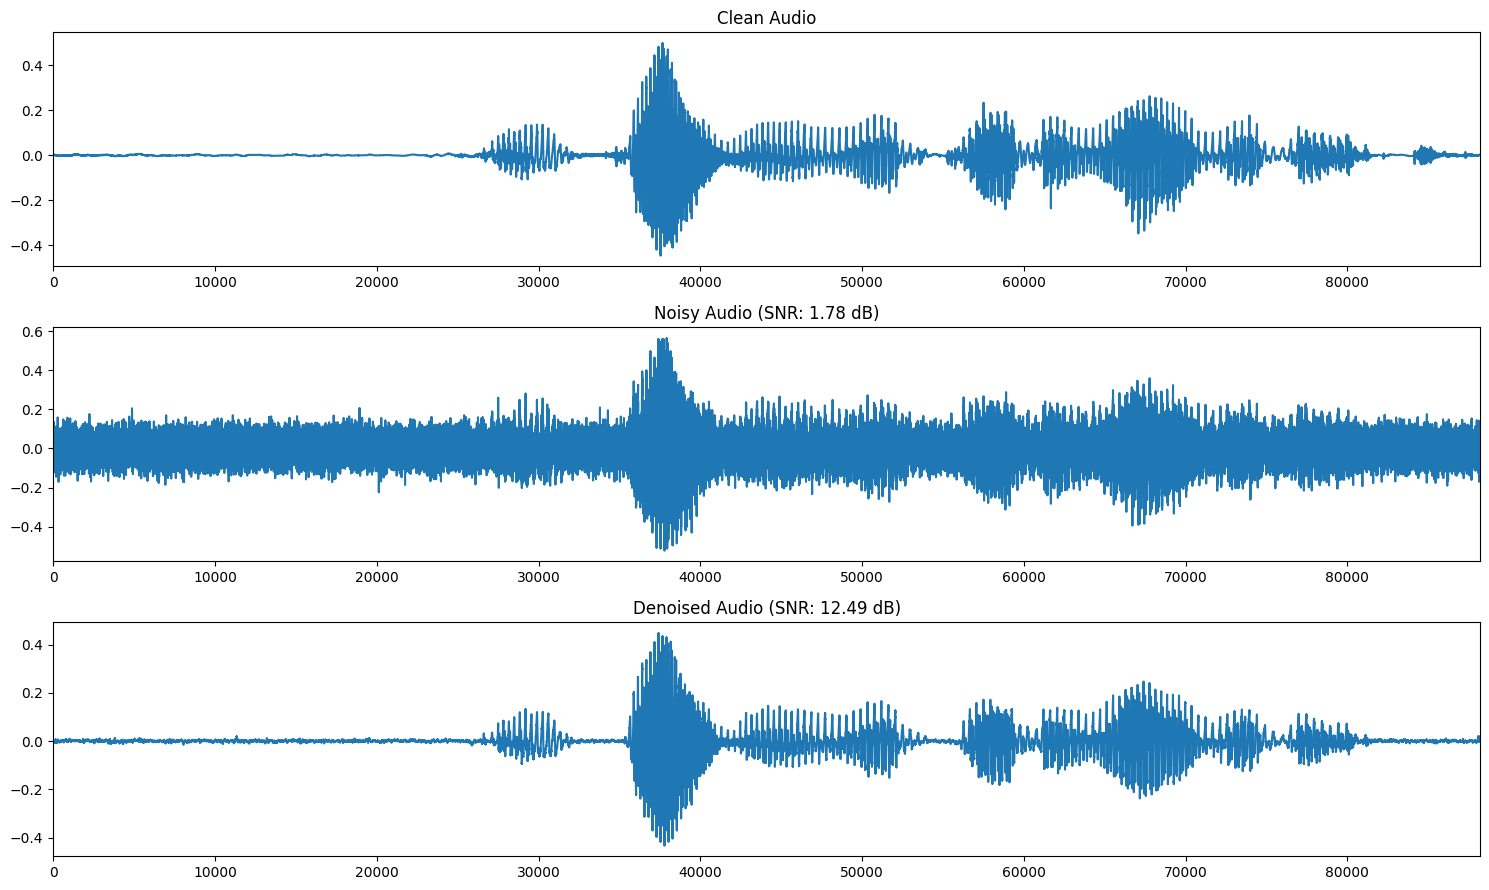

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


In [64]:
# generate and save denoised outputs using best model
os.makedirs(denoised_tuned_folder, exist_ok=True)
for idx, file in enumerate(valid_files):
    denoised = best_model.predict(X_noisy[idx].reshape(1, 88200, 1))
    sf.write(os.path.join(denoised_tuned_folder, file), denoised.flatten(), 44100)
    if idx == 0:
        plot_waveforms(X_clean[idx].flatten(), X_noisy[idx].flatten(), denoised.flatten(), "tuned_comparison")


In [65]:
# Print project completion message in bold letters
print("\033[1mProject completed!\033[0m")

Project completed!
